# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from get_adult_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


## 2. Configuration

In [ ]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.355       # Binary Label Noise probability
#disc_factor = np.pi/2     # Similarity of Y_sen to X
#n_samples = 2000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                 # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd = 0.5                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= -2
lmd_end= 8
lmd_interval = np.linspace(lmd_start, lmd_end, 20)
symmetric_fairness = False

## 3. Data Generation

In [3]:
X_train, Y_train, Y_sen_train, X_test, Y_test, Y_sen_test = get_adult_data()
Y_train_corrupted = add_sym_noise(Y_train, flip_prob, rnd_seed)
Y_sen_train_corrupted = add_sym_noise(Y_sen_train, 0, rnd_seed) #We don't need to extra corrupt the sensitive attribute, because we already corrupted the input.

"""
# Split data
split_index = int(split_ratio * len(X_train))
X_train, X_val =                   X_train[:split_index],               X_train[split_index:]
Y_train, Y_val =                   Y_train[:split_index],               Y_train[split_index:]
Y_train_corrupted, Y_val_corrupted =Y_train_corrupted[:split_index],     Y_train_corrupted[split_index:]
Y_sen_train, Y_sen_val =           Y_sen_train[:split_index],           Y_sen_train[split_index:]
Y_sen_train_corrupted, Y_sen_val_corrupted = Y_sen_train_corrupted[:split_index], Y_sen_train_corrupted[split_index:]
"""

[0 1]


'\n# Split data\nsplit_index = int(split_ratio * len(X_train))\nX_train, X_val =                   X_train[:split_index],               X_train[split_index:]\nY_train, Y_val =                   Y_train[:split_index],               Y_train[split_index:]\nY_train_corrupted, Y_val_corrupted =Y_train_corrupted[:split_index],     Y_train_corrupted[split_index:]\nY_sen_train, Y_sen_val =           Y_sen_train[:split_index],           Y_sen_train[split_index:]\nY_sen_train_corrupted, Y_sen_val_corrupted = Y_sen_train_corrupted[:split_index], Y_sen_train_corrupted[split_index:]\n'

In [4]:
import numpy as np

def phi_from_table(y, s):
    y = np.asarray(y, dtype=int)
    s = np.asarray(s, dtype=int)

    a = np.sum((y==1) & (s==1))  # 1-1
    b = np.sum((y==1) & (s==0))  # 1-0
    c = np.sum((y==0) & (s==1))  # 0-1
    d = np.sum((y==0) & (s==0))  # 0-0

    denom = np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
    return np.nan if denom == 0 else (a*d - b*c) / denom

phi = phi_from_table(Y_test, Y_sen_test)
phi

-0.21189201138169847

## 4. Model Training

In [5]:
# Initialize and train models
p_reg = LogisticRegression().fit(X_train, Y_train)
p_reg_cor = LogisticRegression().fit(X_train, Y_train_corrupted)
f_reg = LogisticRegression().fit(X_train, Y_sen_train)
f_reg_cor = LogisticRegression().fit(X_train, Y_sen_train_corrupted)

/home/ptr@itd.local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ptr@itd.local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

## 5. Finetuning cost Parameters c and c_bar

In [6]:
"""
# ---------- Example usage over your lmd_interval ----------
# Pick your grids (finer grid => more precise but slower)
c_grid = np.linspace(0.0, 1.0, 101)
cbar_grid = np.linspace(0.0, 1.0, 101)

results = []
for lmd in lmd_interval:
    c_opt, cbar_opt, ber_opt, md_opt = tune_c_and_cbar_separately(
        p_reg=p_reg,
        f_reg=f_reg,
        X_val=X_val,
        Y_val=Y_val,
        Y_sen_val=Y_sen_val,
        lmd=lmd,
        symmetric_fairness=symmetric_fairness,
        c_grid=c_grid,
        cbar_grid=cbar_grid,
        init_c=0.5,
        init_cbar=0.5,
        max_iters=3   # usually enough; raise if you want
    )
    results.append({
        "lambda": lmd,
        "c": c_opt,
        "c_bar": cbar_opt,
        "BER_val": ber_opt,
        "MD_val": md_opt
    })

results
"""

'\n# ---------- Example usage over your lmd_interval ----------\n# Pick your grids (finer grid => more precise but slower)\nc_grid = np.linspace(0.0, 1.0, 101)\ncbar_grid = np.linspace(0.0, 1.0, 101)\n\nresults = []\nfor lmd in lmd_interval:\n    c_opt, cbar_opt, ber_opt, md_opt = tune_c_and_cbar_separately(\n        p_reg=p_reg,\n        f_reg=f_reg,\n        X_val=X_val,\n        Y_val=Y_val,\n        Y_sen_val=Y_sen_val,\n        lmd=lmd,\n        symmetric_fairness=symmetric_fairness,\n        c_grid=c_grid,\n        cbar_grid=cbar_grid,\n        init_c=0.5,\n        init_cbar=0.5,\n        max_iters=3   # usually enough; raise if you want\n    )\n    results.append({\n        "lambda": lmd,\n        "c": c_opt,\n        "c_bar": cbar_opt,\n        "BER_val": ber_opt,\n        "MD_val": md_opt\n    })\n\nresults\n'

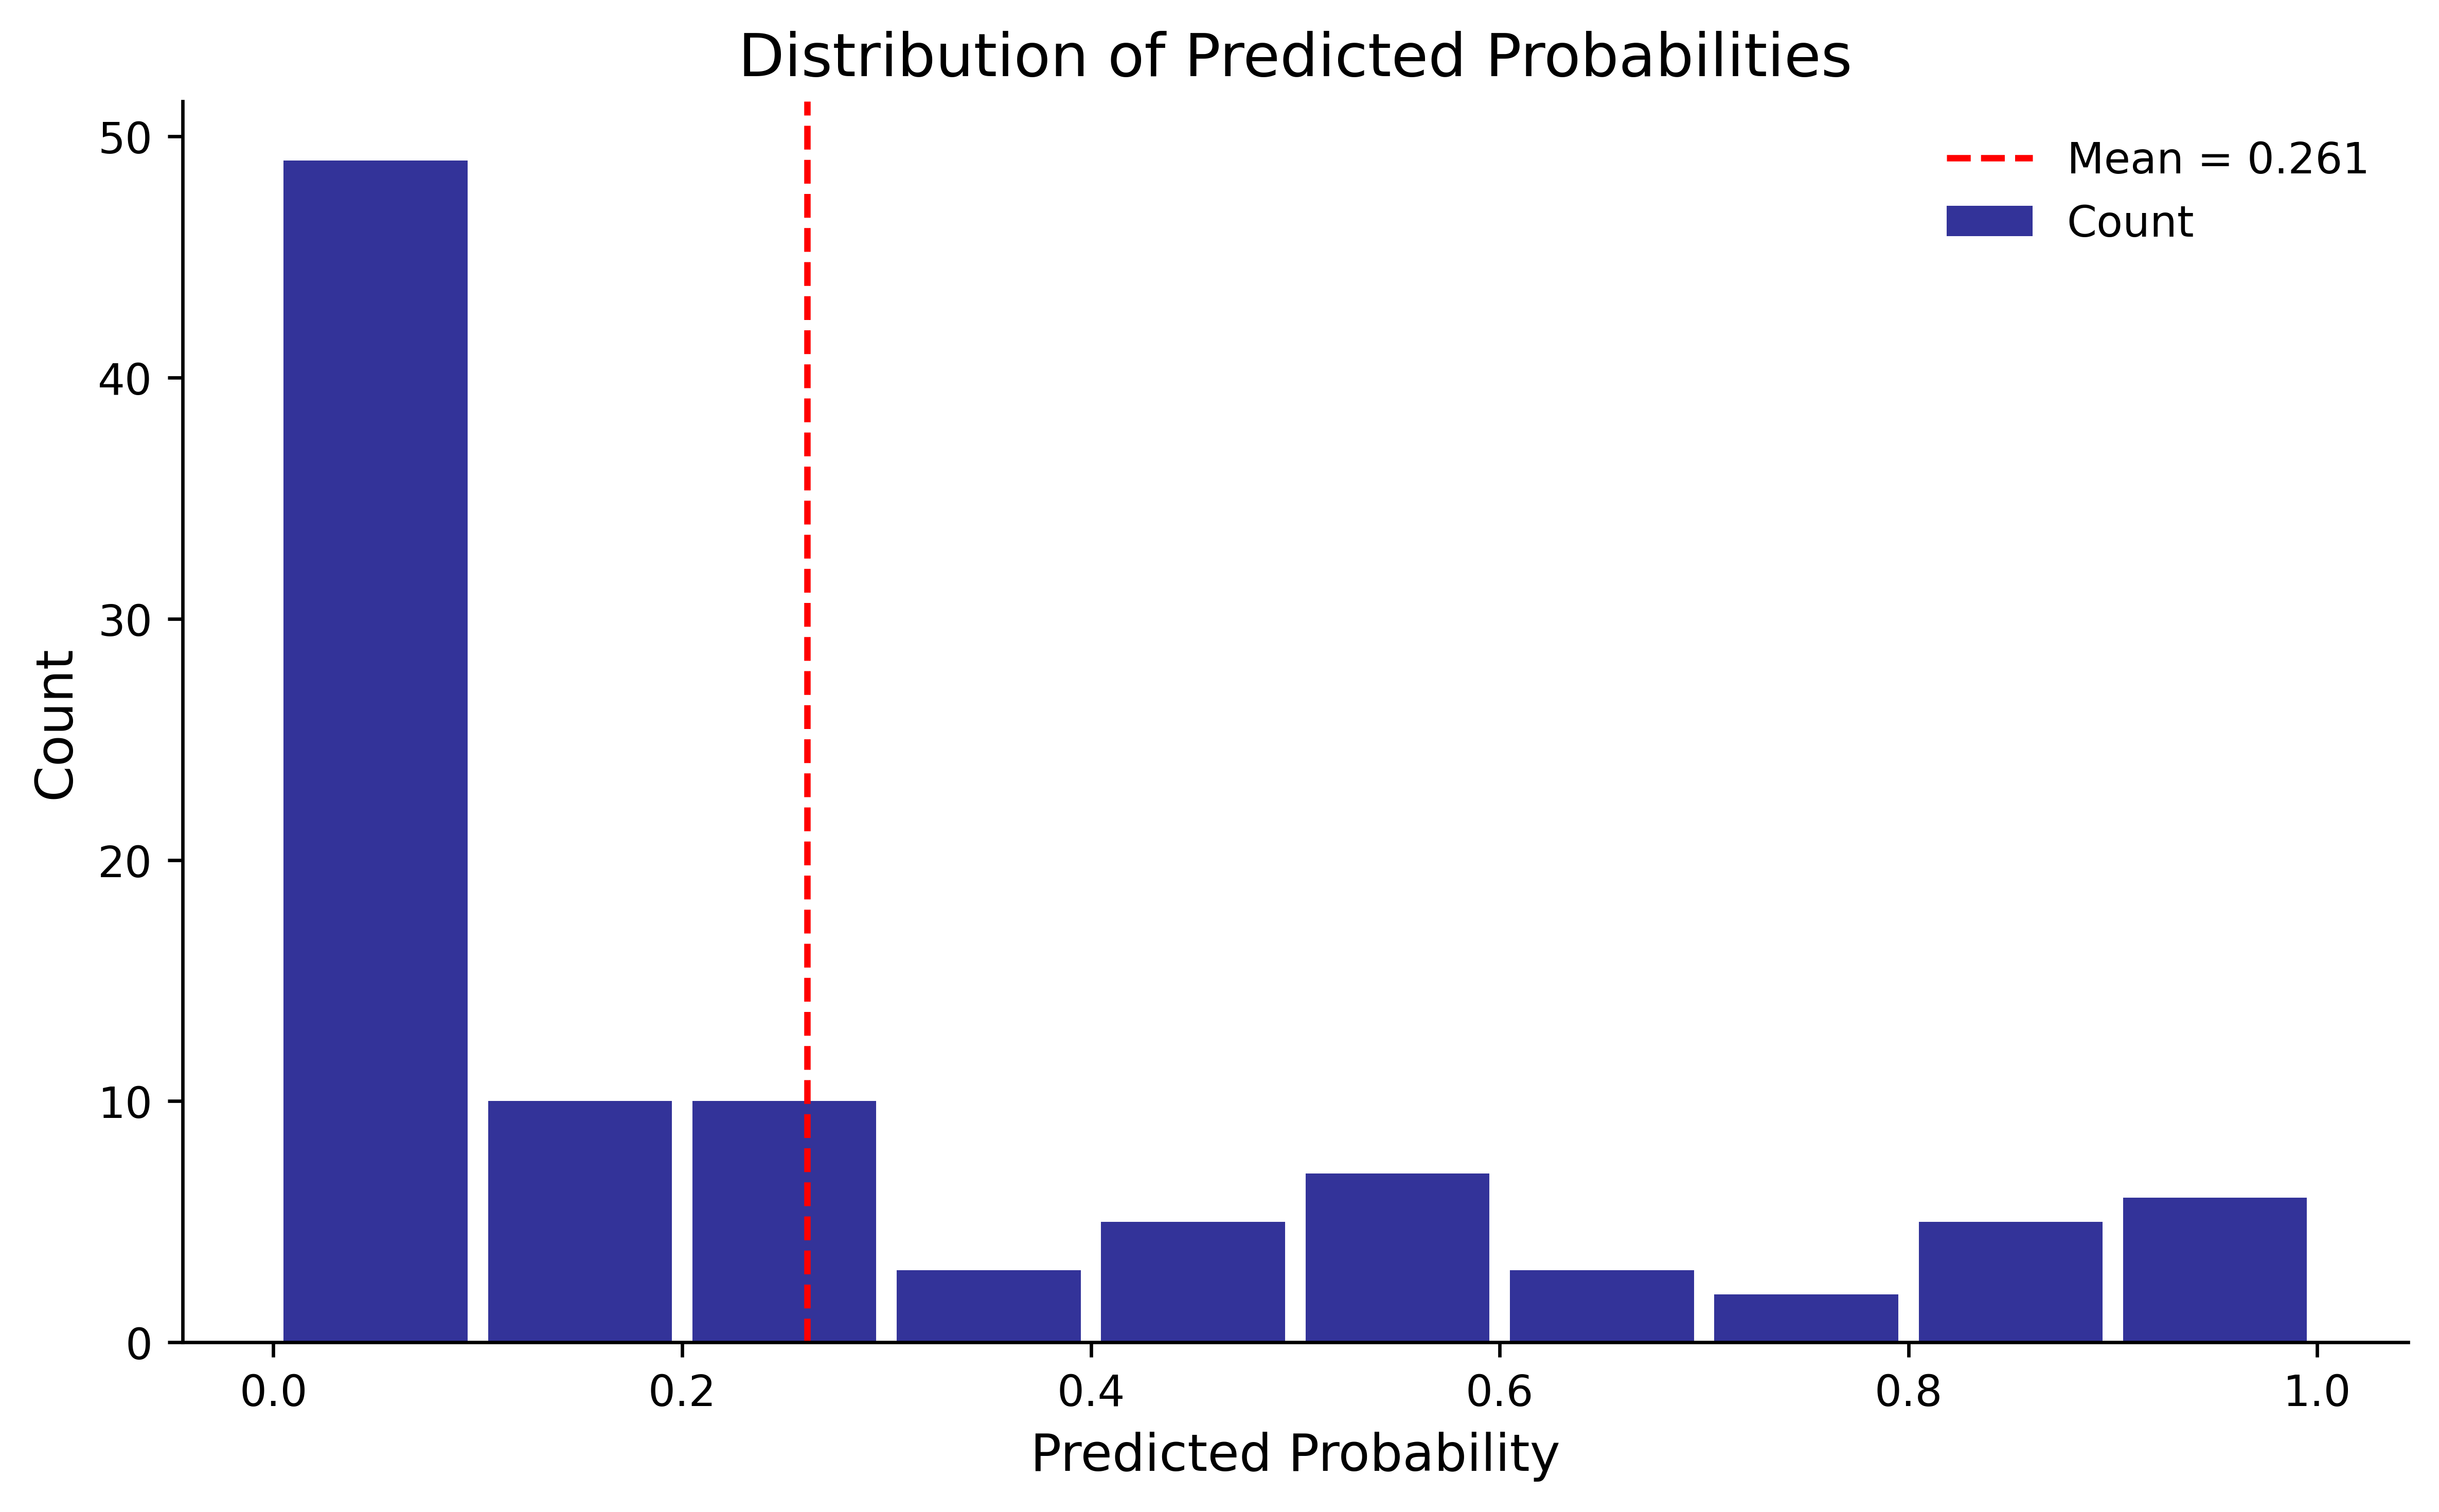

In [7]:
arr = p_reg.predict_proba(X_test[:100])[:, 1]
mean_val = arr.mean()

# Define bins
bins = np.arange(0, 1.1, 0.1)  # 0 to 1 in steps of 0.1

# Histogram
counts, edges = np.histogram(arr, bins=bins)

# Midpoints for plotting
bin_centers = (edges[:-1] + edges[1:]) / 2

# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(bin_centers, counts, width=0.09, color='navy', alpha=0.8, label='Count')
ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean = {mean_val:.3f}')

ax.set_xlabel("Predicted Probability", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of Predicted Probabilities", fontsize=14)

ax.legend(frameon=False, fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 6. Metric Calculation: BER and Fairness

In [8]:
# Sweep over lambda values and calculate metrics
BER_list = []
MD_list = []
DI_list = []
BER_list_corr = []
MD_list_corr = []
DI_list_corr = []

# lmd = how important is fairness
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)
    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
    DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)


# Compute now with Corrupted labels
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s_2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg_cor.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred_2 = np.where(s_2 > 0, 1, 0)

    BER_2 = calc_BER(Y_pred_2, Y_test)
    MD_2 = calc_MD(Y_pred_2, Y_sen_test, symmetric_fairness)
    DI_2 = calc_DI(Y_pred_2, Y_sen_test, symmetric_fairness)
    
    BER_list_corr.append(BER_2)
    MD_list_corr.append(MD_2)
    DI_list_corr.append(DI_2)

In [9]:
# Store results in DataFrame
results = pd.DataFrame({
    'lambda': lmd_interval,
    'BER_clean': BER_list,
    'MD_clean': MD_list,
    'DI_clean': DI_list,
    'BER_corr': BER_list_corr,
    'MD_corr': MD_list_corr,
    'DI_corr': DI_list_corr
})

In [10]:
results

,lambda,BER_clean,MD_clean,DI_clean,BER_corr,MD_corr,DI_corr
0,0.000000,0.263913,0.165713,3.191044,0.300923,0.144007,3.387343
1,0.421053,0.232693,0.323080,5.303235,0.264157,0.590910,7.184019
2,0.842105,0.225557,0.521784,7.578116,0.323224,0.590826,3.933031
3,1.263158,0.251510,0.577840,7.264939,0.345686,0.565501,3.186578
4,1.684211,0.277737,0.613994,6.465456,0.354914,0.553488,2.944561
5,2.105263,0.298920,0.610804,5.123499,0.361133,0.548121,2.825162
6,2.526316,0.313966,0.596288,4.242205,0.363502,0.544332,2.762737
7,2.947368,0.324454,0.586580,3.824024,0.366118,0.539161,2.699298
8,3.368421,0.331648,0.578354,3.553140,0.367506,0.537866,2.676695
9,3.789474,0.337571,0.574835,3.408175,0.368502,0.536665,2.659589


/tmp/ipykernel_443640/2400299160.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_443640/2400299160.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


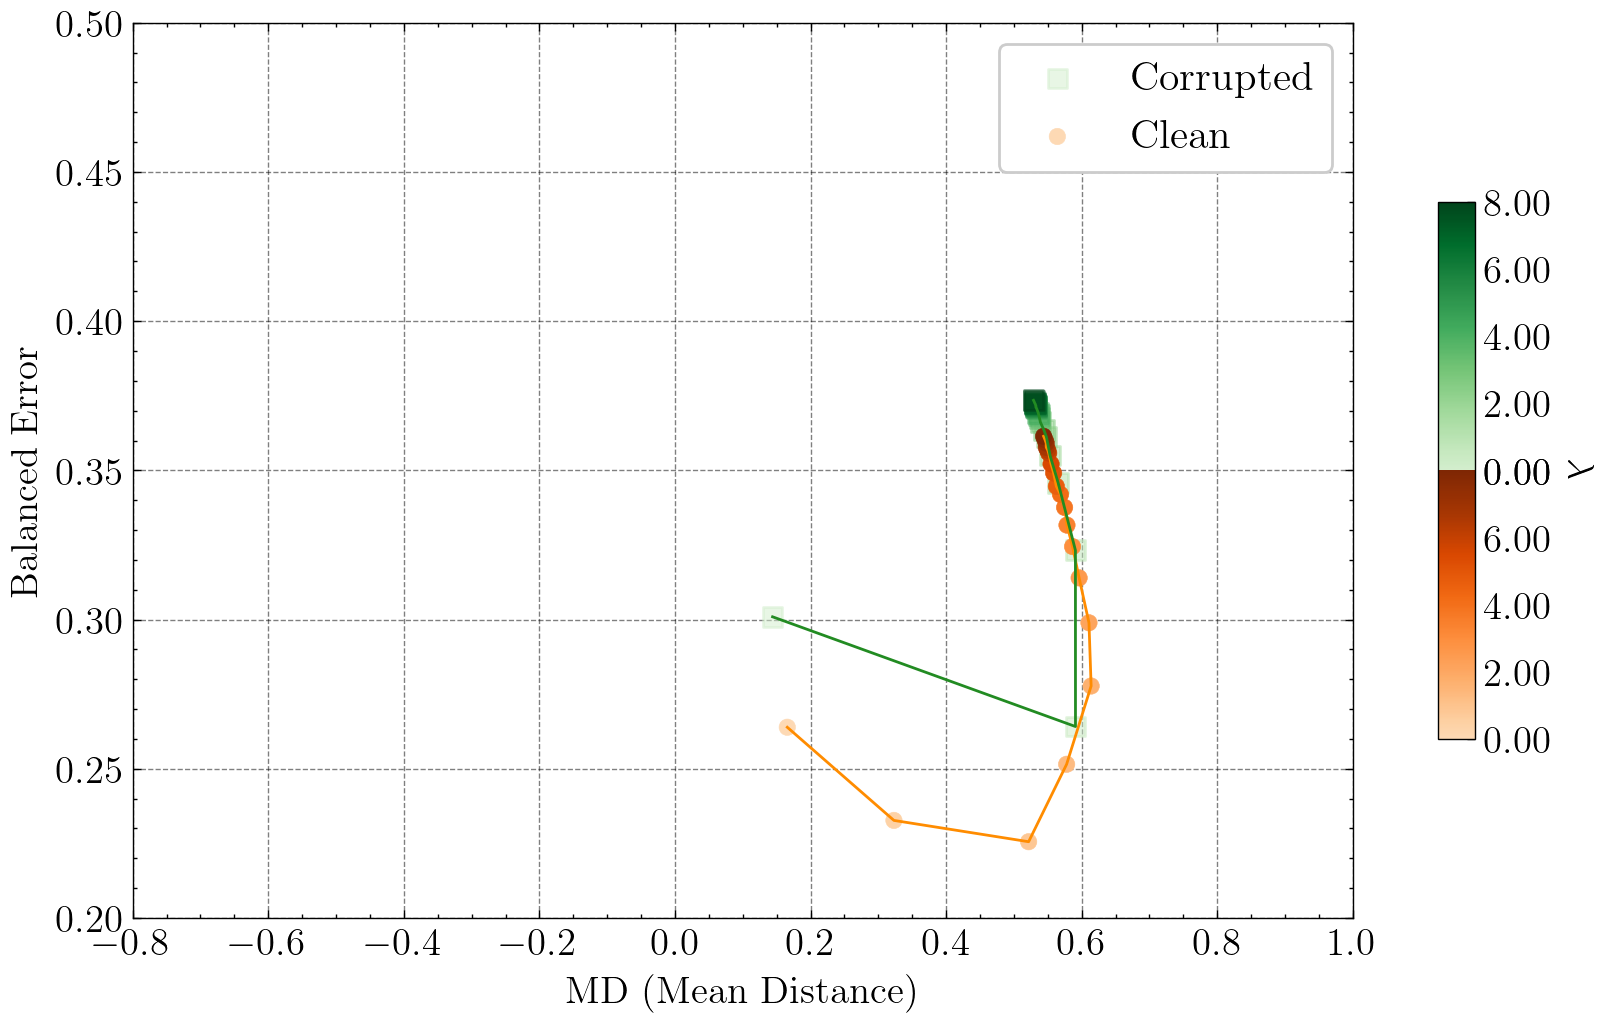

In [13]:
fig = science_fig()
ax = fig.gca()
df = results
df_sorted = df.sort_values(by="lambda")
# Normalize lambda between 0 and 1 for darkness control
lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())

# Truncate colormaps to avoid bright near-white colors
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
green_cmap = truncate_colormap('Greens', 0.2, 1.0)

ax.plot(df_sorted["MD_clean"], df_sorted["BER_clean"],
        color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

# Connect Corrupted data points with a line
ax.plot(df_sorted["MD_corr"], df_sorted["BER_corr"],
        color="forestgreen", linestyle='-', linewidth=1, label="_nolegend_")
# Plot Clean data with orange shades
sc2 = ax.scatter(df["MD_corr"], df["BER_corr"], c=lambda_norm, cmap=green_cmap, label="Corrupted", s=50,marker="s",  alpha=0.5)
sc1 = ax.scatter(df["MD_clean"], df["BER_clean"], c=lambda_norm, cmap=orange_cmap, label="Clean", linewidths= 0.2, s=35)
# Plot Corrupted data


# Create combined colormap by stacking half-orange and half-green
n = 256
orange_colors = orange_cmap(np.linspace(0, 1, n))
green_colors = green_cmap(np.linspace(0, 1, n))
combined_colors = np.vstack((orange_colors, green_colors))
combined_cmap = ListedColormap(combined_colors)

# Dummy image to attach the colorbar to
sm = ax.imshow([np.linspace(0, 1, 2*n)], aspect='auto', cmap=combined_cmap, visible=False)

# Inset axes for compact colorbar (place right next to plot)
cax = inset_axes(ax,
                 width="3%",  # narrow
                 height="60%",  # shorter
                 loc='center right',
                 bbox_to_anchor=(0.1, 0, 1, 1),  # tweak position
                 bbox_transform=ax.transAxes,
                 borderpad=0)


cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)
# Set custom ticks on the colorbar to reflect actual λ values
# Tick positions for each half
ticks_orange = np.linspace(0, 0.5, 5)
ticks_green = np.linspace(0.5, 1.0, 5)

# Map λ values to each range
lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()
ticklabels_orange = np.round(np.linspace(lambda_min, lambda_max, 5), 2)
ticklabels_green = np.round(np.linspace(lambda_min, lambda_max, 5), 2)

# Combine
all_ticks = np.concatenate([ticks_orange, ticks_green])
all_ticklabels = [f"{val:.2f}" for val in ticklabels_orange] + [f"{val:.2f}" for val in ticklabels_green]

# Apply to colorbar
cbar.set_ticks(all_ticks)
cbar.set_ticklabels(all_ticklabels)

# Labels and formatting
ax.set_xlabel("MD (Mean Distance)")
ax.set_ylabel("Balanced Error")
ax.set_xlim(-0.4, 0.05)
ax.set_xlim(-0.8, 1)
ax.set_ylim(0.2, 0.5)
ax.legend()

# Save or show
fig.tight_layout()
#fig.savefig("my_science_figure.png")
fig.show()

/tmp/ipykernel_443640/2688118335.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_443640/2688118335.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


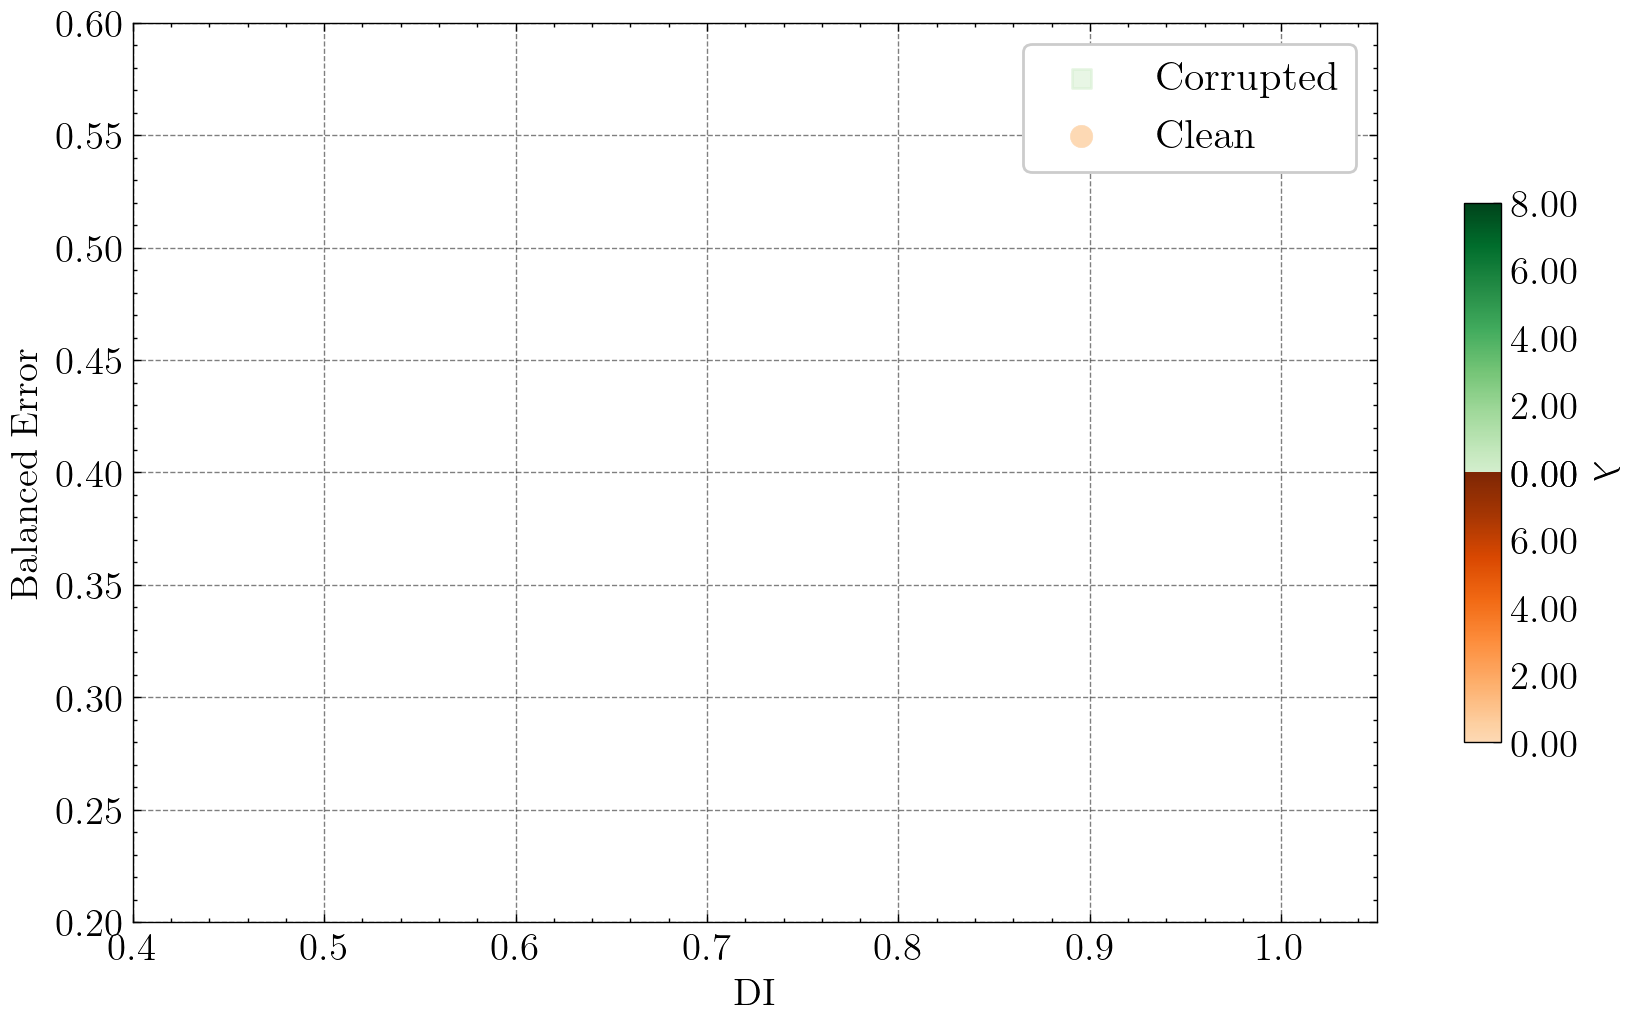

In [12]:
fig = science_fig()
ax = fig.gca()
df = results
df_sorted = df.sort_values(by="lambda")
# Normalize lambda between 0 and 1 for darkness control
lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())

# Truncate colormaps to avoid bright near-white colors
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
green_cmap = truncate_colormap('Greens', 0.2, 1.0)

ax.plot(df_sorted["DI_clean"], df_sorted["BER_clean"],
        color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

# Connect Corrupted data points with a line
ax.plot(df_sorted["DI_corr"], df_sorted["BER_corr"],
        color="forestgreen", linestyle='-', linewidth=1, label="_nolegend_")
# Plot Clean data with orange shades
sc2 = ax.scatter(df["DI_corr"], df["BER_corr"], c=lambda_norm, cmap=green_cmap, label="Corrupted", s=50,marker="s",  alpha=0.5)
sc1 = ax.scatter(df["DI_clean"], df["BER_clean"], c=lambda_norm, cmap=orange_cmap, label="Clean", linewidths= 0.2, s=65)
# Plot Corrupted data



# Create combined colormap by stacking half-orange and half-green
n = 256
orange_colors = orange_cmap(np.linspace(0, 1, n))
green_colors = green_cmap(np.linspace(0, 1, n))
combined_colors = np.vstack((orange_colors, green_colors))
combined_cmap = ListedColormap(combined_colors)

# Dummy image to attach the colorbar to
sm = ax.imshow([np.linspace(0, 1, 2*n)], aspect='auto', cmap=combined_cmap, visible=False)

# Inset axes for compact colorbar (place right next to plot)
cax = inset_axes(ax,
                 width="3%",  # narrow
                 height="60%",  # shorter
                 loc='center right',
                 bbox_to_anchor=(0.1, 0, 1, 1),  # tweak position
                 bbox_transform=ax.transAxes,
                 borderpad=0)




cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)
# Set custom ticks on the colorbar to reflect actual λ values
# Tick positions for each half
ticks_orange = np.linspace(0, 0.5, 5)
ticks_green = np.linspace(0.5, 1.0, 5)

# Map λ values to each range
lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()
ticklabels_orange = np.round(np.linspace(lambda_min, lambda_max, 5), 2)
ticklabels_green = np.round(np.linspace(lambda_min, lambda_max, 5), 2)

# Combine
all_ticks = np.concatenate([ticks_orange, ticks_green])
all_ticklabels = [f"{val:.2f}" for val in ticklabels_orange] + [f"{val:.2f}" for val in ticklabels_green]

# Apply to colorbar
cbar.set_ticks(all_ticks)
cbar.set_ticklabels(all_ticklabels)

# Labels and formatting
ax.set_xlabel("DI" )
ax.set_ylabel("Balanced Error")
ax.set_xlim(0.4, 1.05)
ax.set_ylim(0.2, 0.6)
ax.legend()

# Save or show
fig.tight_layout()
#fig.savefig("my_science_figure.png")
fig.show()

## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
